# Enthalpy calculations in the CPL versus in MOM6

#### SMS_Ld1.T62_t061.GMOM.cheyenne_intel.enthalpy (from Mariana)
/glade/scratch/mvertens/SMS_Ld1.T62_t061.GMOM.cheyenne_intel.enthalpy/run

### Enthalpy terms

For all the **liquid** mass entering the ocean, the enthalpy associated with this mass is defined as:

$$
hliq = max(SST,0.0) \times mass \times c_p ~~~~~~~~~~ (1)
$$

Checking the units:
* SST [C]
* mass [kg m$^{-2}$ s$^{-1}$]
* $c_p$ [J kg$^{-1}$ C$^{-1}$]
* hliq [W m$^{-2}$]

Equation (1) assures that no heat loss can occur when liquid mass is added into the ocean. This formulation is used to calculate the enthalpy associated with rain, liquid runoff, and mass entering the ocean from melting sea ice. These terms are defined as hrain, hrofl, and hmelt, respectively.

For all the **frozen** mass entering the ocean, the enthalpy associated with this mass is defined as:

$$
hfrozen = min(SST,0.0) \times mass \times c_p ~~~~~~~~~~ (2)
$$ 

hmass_frozen is also in [W m$^{-2}$]. Equation (2) is used to calculate the enthalpy associated with snow and frozen runoff. These terms are defined as hsnow and hrofi, respectively.

### Evaporation, what should we do?
Per conversation with Frank Bryan.
If evap < 0, it should leave at SST
If evap > 0, it should enter following (1)

### Correction term

hcorr(n) = (hrain(n) + hsnow(n) + hevap(n) + hrofl(n) + hrofi(n) + hmeltw(n)) * areas(n) * glob_area_inv

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6plot import xyplot

Basemap module not found. Some regional plots may not function properly


In [2]:
path= '/glade/scratch/mvertens/SMS_Ld5.f09_t061.B1850MOM.cheyenne_intel.alpha07b_enthalpy/run/'
grd = MOM6grid(path+'bmom.e23.f09_t061_zstar_N65.nuopc.nuopc_short.003.mom6.static.nc')
area = np.ma.masked_where(grd.wet==0,grd.area_t)
grd_xr = MOM6grid(path+'bmom.e23.f09_t061_zstar_N65.nuopc.nuopc_short.003.mom6.static.nc', xrformat=True)

C_P = 3992.0 
latent_heat_fusion = 3.337E+05
latent_heat_vapor = 2.501E+06

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



### Load data 

In [3]:
ds_mom =  xr.open_dataset(path+'bmom.e23.f09_t061_zstar_N65.nuopc.nuopc_short.003.mom6.frc_0001.nc')

In [4]:
print('Times: ',ds_mom.time.values[:])

Times:  [cftime.DatetimeNoLeap(1, 1, 2, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 1, 3, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 1, 4, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 1, 5, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1, 1, 6, 0, 0, 0, 0, has_year_zero=True)]


In [5]:
ds_cpl = xr.open_mfdataset(path+'SMS_Ld5.f09_t061.B1850MOM.cheyenne_intel.alpha07b_enthalpy.cpl.hi.*.nc')

In [7]:
ds_cpl.time.values

array([cftime.DatetimeNoLeap(1, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 1, 6, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

### Areas

In [8]:
n=0
# areas
#earth_rad = 6.37122e6 # in m (from shr_constants)
earth_rad = 6.378e6 # in m (from MOM6)

model_area = grd.area_t / (earth_rad**2)
med_area = ds_cpl.MED_ocn_area[n,:].values
#med_area = ds_cpl.MED_ocn_area[n,:].values

#med2mod_areacor = med_area/model_area
#mod2med_areacor = model_area/med_area

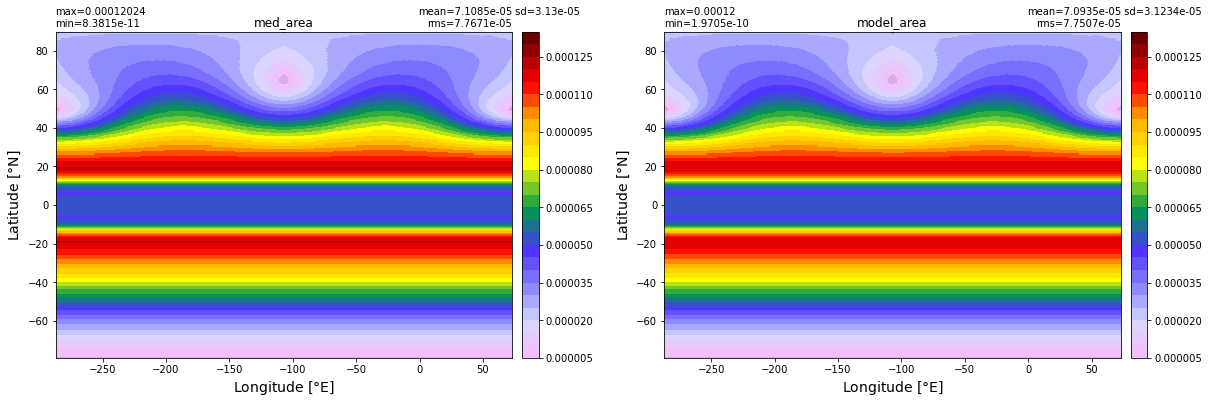

In [9]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax1 = ax.flatten()

xyplot(med_area,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='med_area')
xyplot(model_area,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='model_area')


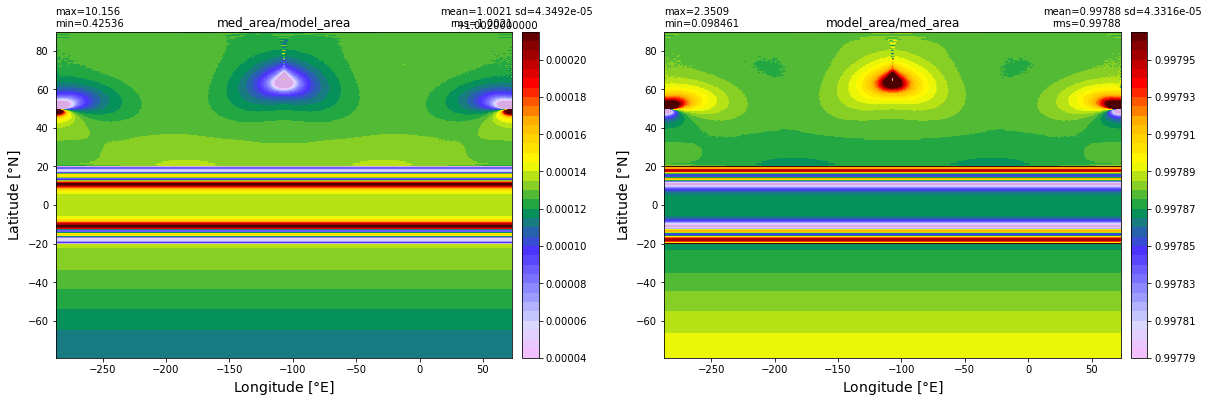

In [10]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax1 = ax.flatten()

#med2mod_areacor = np.ma.masked_where(grd.wet==0,med_area/model_area)
#mod2med_areacor = np.ma.masked_where(grd.wet==0,model_area/med_area)

med2mod_areacor = med_area/model_area
mod2med_areacor = model_area/med_area

xyplot(med2mod_areacor,grd.geolon, grd.geolat, area, axis=ax1[0], title='med_area/model_area')
xyplot(mod2med_areacor,grd.geolon, grd.geolat, area, axis=ax1[1], title='model_area/med_area')


In [11]:
n=1
print(ds_mom.time[n].values)
heat_content_lrunoff = np.ma.masked_invalid(ds_mom.heat_content_lrunoff[n,:].values)* mod2med_areacor
heat_content_frunoff = np.ma.masked_invalid(ds_mom.heat_content_frunoff[n,:].values)* mod2med_areacor
heat_content_icemelt = np.ma.masked_invalid(ds_mom.heat_content_icemelt[n,:].values)* mod2med_areacor
heat_content_lprec = np.ma.masked_invalid(ds_mom.heat_content_lprec[n,:].values)* mod2med_areacor
heat_content_fprec = np.ma.masked_invalid(ds_mom.heat_content_fprec[n,:].values)* mod2med_areacor
heat_content_cond = np.ma.masked_invalid(ds_mom.heat_content_cond[n,:].values)* mod2med_areacor
heat_content_massout = np.ma.masked_invalid(ds_mom.heat_content_massout[n,:].values)* mod2med_areacor
heat_content_massin = np.ma.masked_invalid(ds_mom.heat_content_massin[n,:].values)* mod2med_areacor
heat_content_surfwater = np.ma.masked_invalid(ds_mom.heat_content_surfwater[n,:].values)* mod2med_areacor
heat_content_surfwater = np.ma.masked_invalid(ds_mom.heat_content_surfwater[n,:].values)* mod2med_areacor
Heat_PmE = np.ma.masked_invalid(ds_mom.Heat_PmE[n,:].values)* mod2med_areacor

0001-01-03 00:00:00


### Figures
#### CPL hist vs MOM6

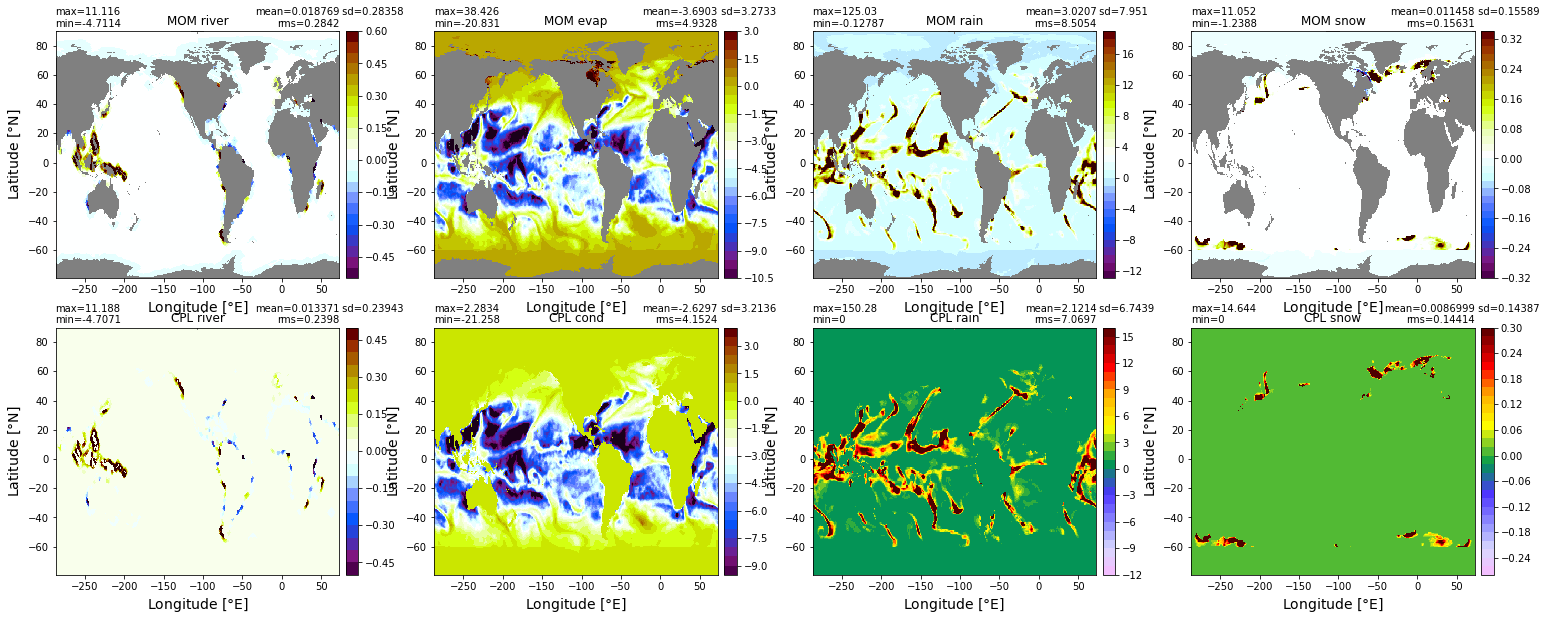

In [15]:
%matplotlib inline
n = 0
ocnExp_Foxx_hevap= np.ma.masked_invalid(ds_cpl.ocnExp_Foxx_hevap[n,:].values) 
ocnExp_Foxx_hrofl= np.ma.masked_invalid(ds_cpl.ocnExp_Foxx_hrofl[n,:].values) 
ocnExp_Foxx_hrofi= np.ma.masked_invalid(ds_cpl.ocnExp_Foxx_hrofi[n,:].values)
ocnExp_Foxx_hrain= np.ma.masked_invalid(ds_cpl.ocnExp_Foxx_hrain[n,:].values) 
ocnExp_Foxx_hsnow= np.ma.masked_invalid(ds_cpl.ocnExp_Foxx_hsnow[n,:].values)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(26,10))
ax1 = ax.flatten()
xyplot(heat_content_lrunoff,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[0], title='MOM river')
xyplot(heat_content_massout,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[1], title='MOM evap')
xyplot(heat_content_lprec,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[2], title='MOM rain')
xyplot(heat_content_fprec,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[3], title='MOM snow')

xyplot(ocnExp_Foxx_hrofl,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[4], title='CPL river')
xyplot(ocnExp_Foxx_hevap,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[5], title='CPL cond')
xyplot(ocnExp_Foxx_hrain,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[6], title='CPL rain')
xyplot(ocnExp_Foxx_hsnow,grd.geolon, grd.geolat, grd.area_t, 
       axis=ax1[7], title='CPL snow')

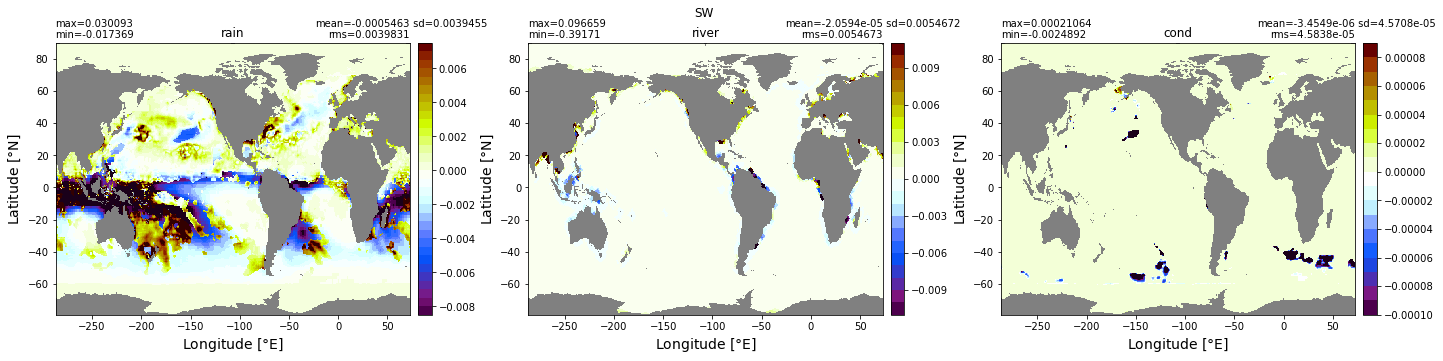

In [39]:
%matplotlib inline


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax1 = ax.flatten()
plt.suptitle('SW')
xyplot(heat_content_lprec-ocnExp_Foxx_hrain, grd.geolon, grd.geolat, grd.area_t, title='rain', 
       axis=ax1[0])
xyplot(heat_content_lrunoff - ocnExp_Foxx_hrofl, grd.geolon, grd.geolat, grd.area_t, title='river', 
       axis=ax1[1])
xyplot(heat_content_cond-ocnExp_Foxx_hcond, grd.geolon, grd.geolat, grd.area_t, title='cond', 
       axis=ax1[2])

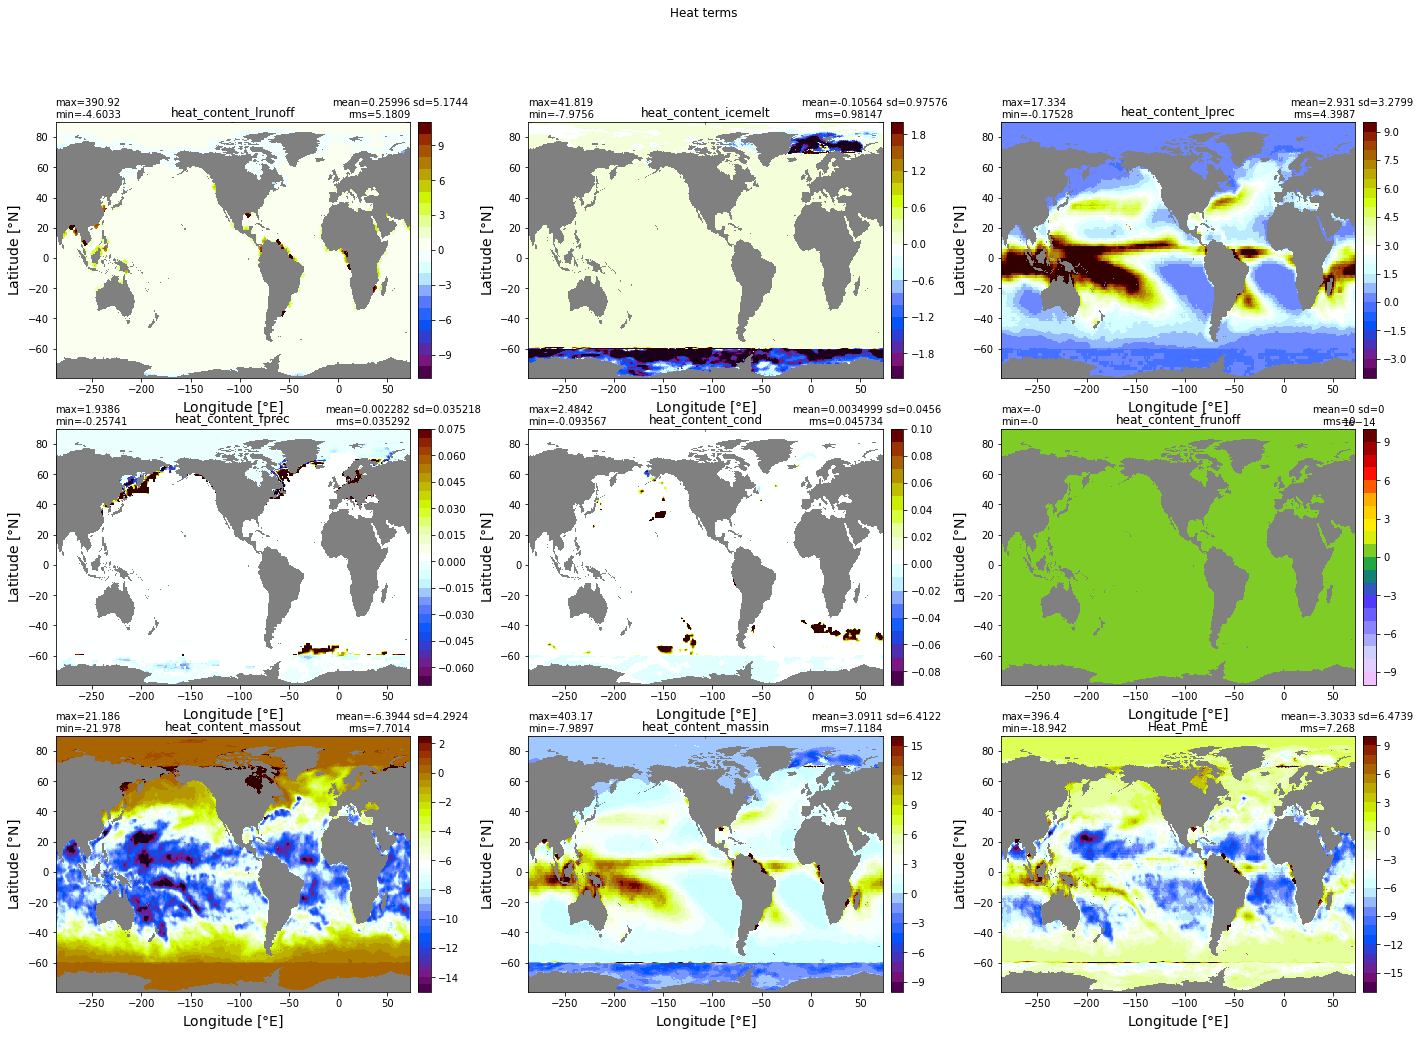

In [28]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24,16))
ax1 = ax.flatten()
plt.suptitle('Heat terms')
xyplot(heat_content_lrunoff,grd.geolon, grd.geolat, grd.area_t, axis=ax1[0], title='heat_content_lrunoff')
xyplot(heat_content_icemelt,grd.geolon, grd.geolat, grd.area_t, axis=ax1[1], title='heat_content_icemelt')
xyplot(heat_content_lprec,grd.geolon, grd.geolat, grd.area_t, axis=ax1[2], title='heat_content_lprec')

xyplot(heat_content_fprec,grd.geolon, grd.geolat, grd.area_t, axis=ax1[3], title='heat_content_fprec')
xyplot(heat_content_cond,grd.geolon, grd.geolat, grd.area_t, axis=ax1[4], title='heat_content_cond')
xyplot(heat_content_frunoff,grd.geolon, grd.geolat, grd.area_t, axis=ax1[5], title='heat_content_frunoff')

xyplot(heat_content_massout,grd.geolon, grd.geolat, grd.area_t, axis=ax1[6], title='heat_content_massout')
xyplot(heat_content_massin,grd.geolon, grd.geolat, grd.area_t, axis=ax1[7], title='heat_content_massin')
xyplot(Heat_PmE,grd.geolon, grd.geolat, grd.area_t, axis=ax1[8], title='Heat_PmE')